In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
import IPython.display as ipd
from model.resnet import resnet152, resnet34

from utils.dataloader import CaptchaDataset

from sklearn.model_selection import train_test_split
import os

# hyperparameter

In [2]:
EPOCHS = 1
CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if CUDA else 'cpu'
MODEL_PATH = './weights/resnet34_ceal'
INIT_MODEL_PATH = './weights/resnet34_ceal_init'
BATCH_SIZE = 1
PATIENCE = 10

In [3]:
INITIAL_ANNOTATED_PERCENT = 0.1
MAXIMUM_ITERATIONS = 30
THRESHOLD_DECAY = 0.0033
_DELTA = 0.05
UNCERTAIN_SAMPLES_SIZE = 1000
UNCERTAIN_CRITERIA = 'lc'
COST_EFFECTIVE = True
FINE_TUNNING_INTERVAL = 1

# dataloader

In [4]:
image_transform = transforms.Compose([
    # transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

dataset = CaptchaDataset('./Large_Captcha_Dataset', isFilter=True, isCrop=True)

In [5]:
random_seed = 123
test_split = 0.2
validation_split = 0.1
shuffling_dataset = True
dataset_size = len(dataset) # 82328

In [6]:
indices = list(range(dataset_size))
test_split_size = int(np.floor(test_split * dataset_size)) # 16465
validation_split_size = int(np.floor((dataset_size-test_split) * validation_split)) # 8232

In [7]:
if shuffling_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[test_split_size:], indices[:test_split_size]
train_indices, val_indices = train_indices[validation_split_size:], train_indices[:validation_split_size]

In [8]:
train_sampler = SubsetRandomSampler(train_indices) # 57631
valid_sampler = SubsetRandomSampler(val_indices) # 8232
test_sampler = SubsetRandomSampler(test_indices) # 16465

In [9]:
du = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
dl = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)
dtest = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# train

In [10]:
loss_history = []
val_loss_history = []

In [11]:
def train(model, train_dataloader):
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    min_loss = 20.
    stop_cnt = 0
    for e in range(EPOCHS):
        start_time = time.time()
        current_loss = []
        current_val_loss = []

        for (x, y) in tqdm(train_dataloader):
            optimizer.zero_grad()
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

            pred1, pred2, pred3, pred4, pred5 = model(x)

            loss1 = criterion(pred1, y1)
            loss2 = criterion(pred2, y2)
            loss3 = criterion(pred3, y3)
            loss4 = criterion(pred4, y4)
            loss5 = criterion(pred5, y5)
            loss = loss1 + loss2 + loss3 + loss4 + loss5
            current_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        current_loss = np.mean(current_loss).item()
        loss_history.append(current_loss)

        if current_loss < min_loss:
            min_loss = current_loss
            torch.save(model.state_dict(), MODEL_PATH)

        # ipd.clear_output(wait=True)
        print(f"{e+1}/{EPOCHS}, {time.time()-start_time:.2f} sec/epoch")
        print(f"current loss={current_loss:.4f}")
        plt.figure(figsize=(20,1),dpi=120)
        plt.scatter(np.arange(len(loss_history)), loss_history, label='train')
        plt.legend(loc=1)
        plt.show()


# test

In [12]:
def evaluate(model, test_dataloader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    pred_list = [[] for i in range(5)]
    true_list = [[] for i in range(5)]
    current_loss = []

    for (x, y) in tqdm(test_dataloader):
        with torch.no_grad():
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

            pred1, pred2, pred3, pred4, pred5 = model(x)
            
            loss1 = criterion(pred1, y1)
            loss2 = criterion(pred2, y2)
            loss3 = criterion(pred3, y3)
            loss4 = criterion(pred4, y4)
            loss5 = criterion(pred5, y5)
            loss = loss1 + loss2 + loss3 + loss4 + loss5
            current_loss.append(loss.item())
            
            
            pred1 = torch.argmax(pred1, -1)
            pred2 = torch.argmax(pred2, -1)
            pred3 = torch.argmax(pred3, -1)
            pred4 = torch.argmax(pred4, -1)
            pred5 = torch.argmax(pred5, -1)
            

            pred_list[0] += pred1.detach().cpu().tolist()
            pred_list[1] += pred2.detach().cpu().tolist()
            pred_list[2] += pred3.detach().cpu().tolist()
            pred_list[3] += pred4.detach().cpu().tolist()
            pred_list[4] += pred5.detach().cpu().tolist()

            true_list[0] += y1.detach().cpu().tolist()
            true_list[1] += y2.detach().cpu().tolist()
            true_list[2] += y3.detach().cpu().tolist()
            true_list[3] += y4.detach().cpu().tolist()
            true_list[4] += y5.detach().cpu().tolist()
            
    pred_list = np.array(pred_list)
    true_list = np.array(true_list)

    loss = np.mean(current_loss).item()
    accuracy = np.sum(pred_list==true_list, axis=1)/true_list.shape[-1]
    
    return loss, accuracy

# CEAL

In [13]:
def initialize_model(init_dataloader, test_dataloader):
    model = resnet34()
    if CUDA:
        model = model.cuda()
    if os.path.exists(INIT_MODEL_PATH):
        print('Load initial model')
        model.load_state_dict(torch.load(INIT_MODEL_PATH))
    else:
        print('Train initial model')
        train(model, init_dataloader)
        torch.save(model.state_dict(), INIT_MODEL_PATH)
    print('Eval initial model')
    loss, acc = evaluate(model, test_dataloader)
    print('Initial Test Loss: ', loss, '\nInitial Test Accuracy: ', acc)
    return model

In [14]:
# Random sampling
def random_sampling(y_pred_prob, n_samples):
    return np.random.choice(range(len(y_pred_prob)), n_samples)

In [49]:
# Rank all the unlabeled samples in an ascending order according to the least confidence
def least_confidence(y_pred_prob, n_samples):
    """
    y_pred_prob: (N, 5, 62)
    """
    origin_index = np.arange(0, len(y_pred_prob)) # (N)
    # max_prob = np.max(y_pred_prob, axis=1) # (N, 62)
    max_prob = np.max(y_pred_prob, axis=2) # (N, 5)
    mean_prob = np.mean(max_prob, axis=1) # (N,)
    # pred_label = np.argmax(y_pred_prob, axis=1) # (N, 62)
    # pred_label = np.argmax(y_pred_prob, axis=2) # (N, 5)

    # lci = np.column_stack((origin_index,
    #                        max_prob,
    #                        pred_label))
    lci = np.column_stack((origin_index,
                       mean_prob))
    lci = lci[lci[:, 1].argsort()]
    return lci[:n_samples], lci[:, 0].astype(int)[:n_samples]

In [16]:
# Rank all the unlabeled samples in an ascending order according to the margin sampling
def margin_sampling(y_pred_prob, n_samples):
    origin_index = np.arange(0, len(y_pred_prob))
    # margim_sampling = np.diff(-np.sort(y_pred_prob)[:, ::-1][:, :2]) # (N, 1)
    margim_sampling = np.diff(-np.sort(y_pred_prob)[:, :, ::-1][:, :, :2]) # (N, 5, 1)
    margim_sampling_mean = np.mean(margim_sampling, axis=1) # (N, 1)
    # pred_label = np.argmax(y_pred_prob, axis=1)
    # msi = np.column_stack((origin_index,
    #                        margim_sampling,
    #                        pred_label))
    msi = np.column_stack((origin_index,
                           margim_sampling_mean))
    msi = msi[msi[:, 1].argsort()]
    return msi[:n_samples], msi[:, 0].astype(int)[:n_samples]

In [17]:
# Rank all the unlabeled samples in an descending order according to their entropy
def entropy(y_pred_prob, n_samples):
    # entropy = stats.entropy(y_pred_prob.T)
    # entropy = np.nan_to_num(entropy)
    origin_index = np.arange(0, len(y_pred_prob))
    # entropy = -np.nansum(np.multiply(y_pred_prob, np.log(y_pred_prob)), axis=1) # (4,)
    entropy = -np.nansum(np.multiply(y_pred_prob, np.log(y_pred_prob)), axis=2) # (4, 5)
    mean_entropy = np.mean(entropy, axis=1) # (4,)
    
    # pred_label = np.argmax(y_pred_prob, axis=1)
    # eni = np.column_stack((origin_index,
    #                        entropy,
    #                        pred_label))
    eni = np.column_stack((origin_index,
                           mean_entropy))

    eni = eni[(-eni[:, 1]).argsort()]
    return eni[:n_samples], eni[:, 0].astype(int)[:n_samples]

In [ ]:
def ?????(y_pred_prob, n_samples):
    pass

In [18]:
def get_high_confidence_samples(y_pred_prob, delta):
    eni, eni_idx = entropy(y_pred_prob, len(y_pred_prob))
    hcs = eni[eni[:, 1] < delta]
    return hcs[:, 0].astype(int), hcs[:, 2].astype(int)

In [19]:
def get_uncertain_samples(y_pred_prob, n_samples, criteria):
    if criteria == 'lc':
        return least_confidence(y_pred_prob, n_samples)
    elif criteria == 'ms':
        return margin_sampling(y_pred_prob, n_samples)
    elif criteria == 'en':
        return entropy(y_pred_prob, n_samples)
    elif criteria == 'rs':
        return None, random_sampling(y_pred_prob, n_samples)
    else:
        raise ValueError(
            'Unknown criteria value \'%s\', use one of [\'rs\',\'lc\',\'ms\',\'en\']' % criteria)

In [ ]:
accs = 

In [20]:
def run_ceal():
    model = initialize_model(dl, dtest)
    _DELTA = 0.05
    
    for i in range(MAXIMUM_ITERATIONS):
        y_pred_probs = []
        for (x, y) in tqdm(du):
            x = x.to(DEVICE)
            y_pred_prob = model(x)
            y_pred_prob = list(map(lambda _y: (nn.functional.softmax(_y, dim=-1)).detach().cpu().numpy(), y_pred_prob))
            y_pred_probs.append(y_pred_prob)

        y_pred_probs = np.array(y_pred_probs)
        y_pred_probs = np.transpose(y_pred_probs, (0, 2, 1, 3)).reshape(-1, 5, 62)

        _, un_idx = get_uncertain_samples(y_pred_probs, UNCERTAIN_SAMPLES_SIZE, criteria=UNCERTAIN_CRITERIA)
        
        un_idx = [du.sampler.indices[idx] for idx in un_idx]
        
        dl.sampler.indices.extend(un_idx)
        
        print(
            f'Update size of `dl` and `du` by adding uncertain {len(un_idx)} samples in `dl`\nlen(dl): {len(dl.sampler.indices)}, len(du): {len(du.sampler.indices)}'
        )
        
        if COST_EFFECTIVE:
            print('COST_EFFECTIVE step')
            hcs_idx, hcs_labels = get_high_confidence_samples(y_pred_prob, _DELTA)
            
            hcs_idx = [du.sampler.indices[idx] for idx in hcs_idx]
            
            hcs_idx = [x for x in hcs_idx if x not in list(set(un_idx) & set(hcs_idx))]
            
            dl.sampler.indices.extend(hcs_idx)
            
            for idx in range(len(hcs_idx)):
                dl.dataset.y[hcs_idx[idx]] = hcs_labels[idx]
        
        if i % FINE_TUNNING_INTERVAL == 0 :
            print('FINE_TUNNING step')
            train(model, dl)
            _DELTA -= (THRESHOLD_DECAY * FINE_TUNNING_INTERVAL)
        
        for val in un_idx:
            du.sampler.indices.remove(val)
        
        _, acc = evaluate(model, dtest)
        
        print(
            "Iteration: {}, len(dl): {}, len(du): {},"
            " len(dh) {}, acc: {} ".format(
                i, len(dl.sampler.indices),
                len(du.sampler.indices), len(hcs_idx), acc))



Load initial model
Eval initial model


100%|████████████████████████████████████| 16465/16465 [01:20<00:00, 204.14it/s]


Initial Test Loss:  18.304498833796192 
Initial Test Accuracy:  [0.26310355 0.12395991 0.14357729 0.15827513 0.1987853 ]


100%|████████████████████████████████████| 57631/57631 [05:08<00:00, 186.77it/s]


(57631, 5, 1, 62)
(57631, 5, 62)
Update size of `dl` and `du` by adding uncertain 1000 samples in `dl`
len(dl): 9232, len(du): 57631
COST_EFFECTIVE step
FINE_TUNNING step


100%|███████████████████████████████████████| 9232/9232 [03:32<00:00, 43.43it/s]


1/1, 212.74 sec/epoch
current loss=16.4286


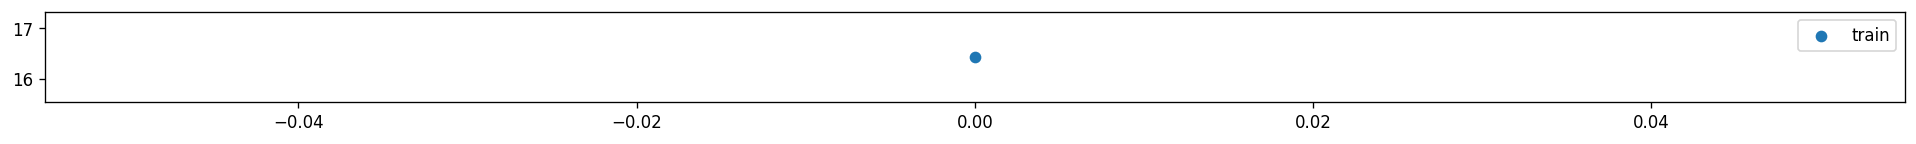

100%|████████████████████████████████████| 16465/16465 [01:18<00:00, 208.44it/s]


Iteration: 0, len(dl): 9232, len(du): 56631, len(dh) 0, acc: [0.3519587  0.168843   0.18639538 0.21056787 0.3039174 ] 


100%|████████████████████████████████████| 56631/56631 [04:55<00:00, 191.50it/s]


(56631, 5, 1, 62)
(56631, 5, 62)
Update size of `dl` and `du` by adding uncertain 1000 samples in `dl`
len(dl): 10232, len(du): 56631
COST_EFFECTIVE step
FINE_TUNNING step


100%|█████████████████████████████████████| 10232/10232 [03:51<00:00, 44.21it/s]


1/1, 231.58 sec/epoch
current loss=15.3403


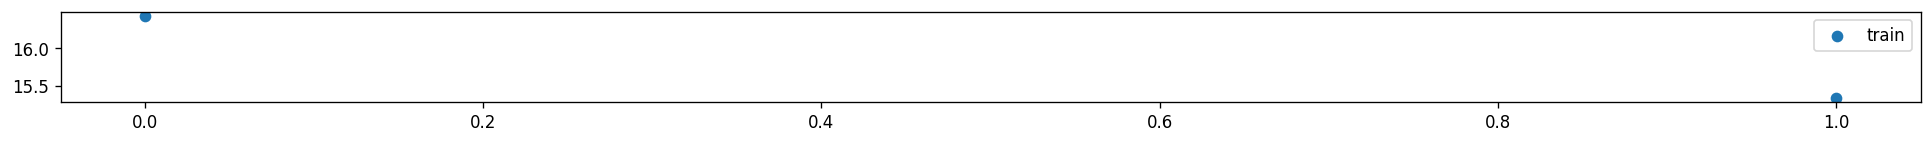

100%|████████████████████████████████████| 16465/16465 [01:19<00:00, 207.34it/s]


Iteration: 1, len(dl): 10232, len(du): 55631, len(dh) 0, acc: [0.40740966 0.22927422 0.2520498  0.26140298 0.38287276] 


100%|████████████████████████████████████| 55631/55631 [04:50<00:00, 191.43it/s]


(55631, 5, 1, 62)
(55631, 5, 62)
Update size of `dl` and `du` by adding uncertain 1000 samples in `dl`
len(dl): 11232, len(du): 55631
COST_EFFECTIVE step
FINE_TUNNING step


100%|█████████████████████████████████████| 11232/11232 [04:16<00:00, 43.76it/s]


1/1, 256.80 sec/epoch
current loss=14.2446


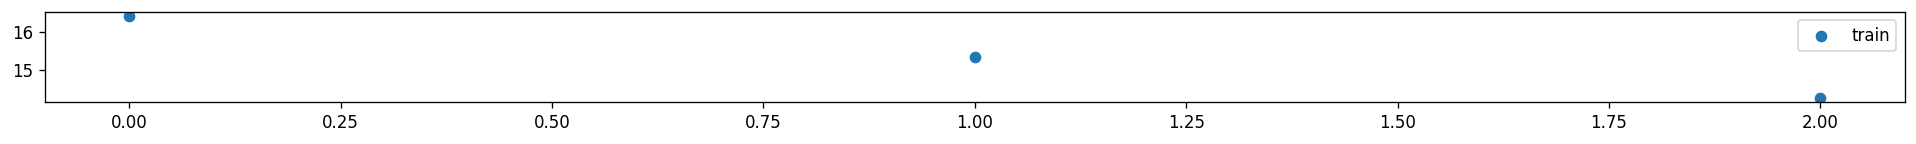

100%|████████████████████████████████████| 16465/16465 [01:20<00:00, 204.59it/s]


Iteration: 2, len(dl): 11232, len(du): 54631, len(dh) 0, acc: [0.45034923 0.3310659  0.32474947 0.32972973 0.44889159] 


100%|████████████████████████████████████| 54631/54631 [04:45<00:00, 191.03it/s]


(54631, 5, 1, 62)
(54631, 5, 62)
Update size of `dl` and `du` by adding uncertain 1000 samples in `dl`
len(dl): 12232, len(du): 54631
COST_EFFECTIVE step
FINE_TUNNING step


100%|█████████████████████████████████████| 12232/12232 [04:43<00:00, 43.09it/s]


1/1, 284.07 sec/epoch
current loss=13.1976


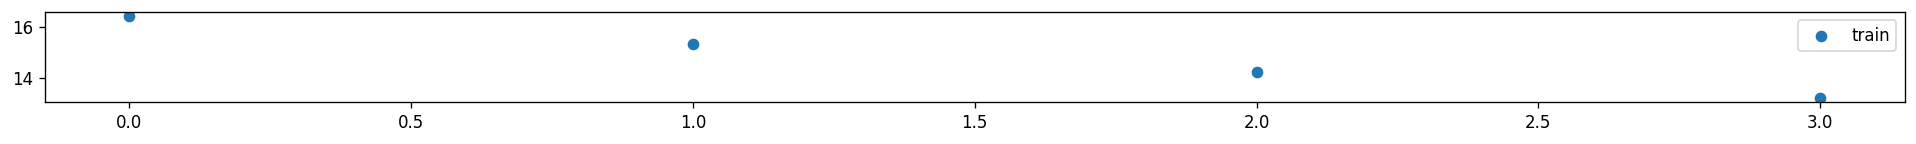

100%|████████████████████████████████████| 16465/16465 [01:20<00:00, 204.62it/s]


Iteration: 3, len(dl): 12232, len(du): 53631, len(dh) 0, acc: [0.45277862 0.38882478 0.34825387 0.3752809  0.46316429] 


100%|████████████████████████████████████| 53631/53631 [04:42<00:00, 189.77it/s]


(53631, 5, 1, 62)
(53631, 5, 62)
Update size of `dl` and `du` by adding uncertain 1000 samples in `dl`
len(dl): 13232, len(du): 53631
COST_EFFECTIVE step
FINE_TUNNING step


100%|█████████████████████████████████████| 13232/13232 [05:06<00:00, 43.17it/s]


1/1, 306.65 sec/epoch
current loss=12.2033


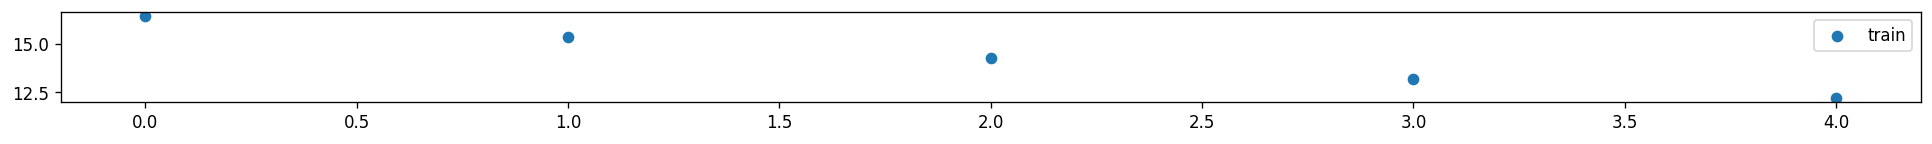

100%|████████████████████████████████████| 16465/16465 [01:20<00:00, 204.70it/s]


Iteration: 4, len(dl): 13232, len(du): 52631, len(dh) 0, acc: [0.47300334 0.42259338 0.39088977 0.41354388 0.47792287] 


100%|████████████████████████████████████| 52631/52631 [04:38<00:00, 189.24it/s]


(52631, 5, 1, 62)
(52631, 5, 62)
Update size of `dl` and `du` by adding uncertain 1000 samples in `dl`
len(dl): 14232, len(du): 52631
COST_EFFECTIVE step
FINE_TUNNING step


 82%|██████████████████████████████▎      | 11672/14232 [04:24<00:57, 44.14it/s]


KeyboardInterrupt: 

In [22]:
run_ceal()

# visalization

In [ ]:
keys = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [ ]:
for (x, y) in dtest:
    with torch.no_grad():
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

        pred1, pred2, pred3, pred4, pred5 = model(x)
        pred1 = torch.argmax(pred1, -1)
        pred2 = torch.argmax(pred2, -1)
        pred3 = torch.argmax(pred3, -1)
        pred4 = torch.argmax(pred4, -1)
        pred5 = torch.argmax(pred5, -1)
        
        y1 = list(map(lambda x: keys[x], y1))
        y2 = list(map(lambda x: keys[x], y2))
        y3 = list(map(lambda x: keys[x], y3))
        y4 = list(map(lambda x: keys[x], y4))
        y5 = list(map(lambda x: keys[x], y5))
        
        pred1 = list(map(lambda x: keys[x], pred1))
        pred2 = list(map(lambda x: keys[x], pred2))
        pred3 = list(map(lambda x: keys[x], pred3))
        pred4 = list(map(lambda x: keys[x], pred4))
        pred5 = list(map(lambda x: keys[x], pred5))
        
        
        for idx in range(BATCH_SIZE):
            true_str = f'{y1[idx]} {y2[idx]} {y3[idx]} {y4[idx]} {y5[idx]}'
            pred_str = f'{pred1[idx]} {pred2[idx]} {pred3[idx]} {pred4[idx]} {pred5[idx]}'
            plt.figure(figsize=(50,50))
            plt.subplot(8, 8, idx+1)
            plt.title(f'{true_str} / {pred_str}')
            plt.imshow(x[idx].detach().cpu().permute(1, 2, 0))
        break